In [1]:
import glob
import pandas as pd
import numpy as np
import os
import tqdm
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import contractions
import re
import string
punctuation_string = string.punctuation
import spacy
nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('en_core_web', disable=['parser', 'ner'])
import dask.dataframe as dd
from dask import delayed
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
sns.set(rc = {'figure.figsize':(8,5)})
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaheedismail/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shaheedismail/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#load published index
df_published = pd.read_csv('./data/GfK Consumer Confidence.csv', infer_datetime_format=True)
df_published=df_published.set_index(['Date'])
df_published.index =pd.to_datetime(df_published.index, infer_datetime_format=True)


In [3]:
def files_in_directory(dir):
    files = []
    for file in os.listdir(dir):
        f = os.path.join(dir, file)
        product = file.split('.')[0]
        if os.path.isfile(f):
            files.append(f)
    return files

files = files_in_directory('./data/tweets')


In [4]:
%%time

dfs=[]
all = False
for file in files:

    try:
        if all:
            if 'economy' in file and file != './data/tweets/.DS_Store':
                df = pd.read_csv(file, low_memory=False,  lineterminator='\n')
                dfs.append(df)
        else:
            df = pd.read_csv(file, low_memory=False,  lineterminator='\n')
            dfs.append(df)
    except Exception as e:
        print(f"Error reading file '{file}': {e}")
        continue

df_all= pd.concat(dfs, ignore_index=True)

#df_all.to_csv('.data/economy_tweets.csv')
#df_all

Error reading file './data/tweets/.DS_Store': 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
CPU times: user 13 s, sys: 2.73 s, total: 15.8 s
Wall time: 25.9 s


In [5]:
%%time

mask = df_all['date'].str.match(r'\d{4}-\d{2}-\d{2}')
df = df_all[mask]
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuation_string += '’'
punctuation = str.maketrans('', '', punctuation_string)
sid_obj = SentimentIntensityAnalyzer()

cleaned = (df
 #.sample(10)
 .loc[mask, :]
 .assign(date=pd.to_datetime(df_all.loc[mask, 'date'])
        .dt.date)
 .query('lang=="en"')
 .drop(columns=df.columns[2:])
 .set_index('date')
 .assign(processed_text=lambda df_: df_.content
         .astype(str)
         .str.lower()
         .apply(word_tokenize)
         .apply(lambda tokens: ' '.join([w for w in tokens if not w in stop_words]))
         .apply(lambda x: contractions.fix(x))
         .apply(lambda x: re.sub('[0-9]+','', x)) #remove numbers
         .apply(lambda x: re.sub('@ [A-z]+','',x)) #remove twitter handles
         .apply(lambda x: x.translate(punctuation))
         .apply(lambda x: re.sub(r'((http|ftp|https)://)?([\w.-]*)\.([\w]*)+',' ', x)) #remove URLs
         .apply(lambda x: re.sub(r'(http|ftp|https)://t\.co/[a-zA-Z0-9\-\.]{10}', ' ', x)) #remove t.co URLs
         .apply(lambda x: re.compile(pattern = "[" 
                                                u"\U0001F600-\U0001F64F"
                                                u"\U0001F300-\U0001F5FF"
                                                u"\U0001F680-\U0001F6FF"
                                                u"\U0001F1E0-\U0001F1FF"
                                                "]+", flags = re.UNICODE)
                                                .sub(r'', x))
         .apply(lambda x: re.sub(u"\uf8ff", '', x))
         .apply(lambda x: ' '.join(x.split()))
         .apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
         .apply(lambda x: re.sub('\s\S(?!\S)|(?<!\S)\S\s', '', x))
         .apply(lambda x: re.sub(r'\b\w{16,}\b', '', x))
        )
 .dropna(subset='processed_text')
 .assign(tb_sentiment_score = lambda df_ : df_.processed_text.apply(lambda x: TextBlob(x).sentiment.polarity))
 .assign(tb_sentiment_cat = lambda df_: np.select([(df_.tb_sentiment_score.between(-0.05, 0.05)),
                                                (df_.tb_sentiment_score>0),
                                                (df_.tb_sentiment_score<0)],
                                                 ['neut', 'pos', 'neg']))
 .astype({'tb_sentiment_cat': 'category'})
 .assign(tb_sentiment_score_round = lambda df_ : df_.tb_sentiment_cat.replace({'pos': 1, 'neut': 0, 'neg': -1}))
 .pipe(lambda df_: df_.set_index(pd.to_datetime(df_.index, format='%Y-%m-%d')))
           
 .assign(vd_sentiment_score = lambda df_ : df_.processed_text.apply(lambda x: sid_obj.polarity_scores(str(x))['compound']))
 .assign(vd_sentiment_cat = lambda df_: np.select([(df_.vd_sentiment_score.between(-0.05, 0.05)),
                                                (df_.vd_sentiment_score>0),
                                                (df_.vd_sentiment_score<0)],
                                                 ['neut', 'pos', 'neg']))
 .astype({'vd_sentiment_cat': 'category'})
 .assign(vd_sentiment_score_round = lambda df_ : df_.vd_sentiment_cat.replace({'pos': 1, 'neut': 0, 'neg': -1}))
 .pipe(lambda df_: df_.set_index(pd.to_datetime(df_.index, format='%Y-%m-%d')))      
 .assign(tokens = lambda df_: df_.processed_text
         .astype(str)
         .apply(word_tokenize))
)


cleaned.sample(5)

CPU times: user 10min 34s, sys: 6.45 s, total: 10min 41s
Wall time: 10min 54s


,content,processed_text,tb_sentiment_score,tb_sentiment_cat,tb_sentiment_score_round,vd_sentiment_score,vd_sentiment_cat,vd_sentiment_score_round,tokens
date,,,,,,,,,
2020-09-29,More restrictions ✅ needs to be swiftly follow...,restriction need swiftly follow financial supp...,0.037500,neut,0,0.8271,pos,1,"[restriction, need, swiftly, follow, financial..."
2020-05-03,I run a Limited company. I employ 7 people. I ...,run limited company employ people business yea...,-0.071429,neg,-1,0.2732,pos,1,"[run, limited, company, employ, people, busine..."
2020-05-25,@LemonKid1978 @bbcburnsy Shame Cummings didn't...,shame cumming not share sentiment say sacrific...,0.083333,pos,1,-0.6041,neg,-1,"[shame, cumming, not, share, sentiment, say, s..."
2019-07-28,@Keltique @gmclarksonz @Janela_X @DougChapmanS...,ireland poor country economy well fuck uk net ...,-0.133333,neg,-1,-0.9382,neg,-1,"[ireland, poor, country, economy, well, fuck, ..."
2020-06-12,~CONTROL WHAT YOU CAN CONTROL~\n\nIn uncertain...,control control uncertainty really easy get cy...,0.433333,pos,1,-0.3197,neg,-1,"[control, control, uncertainty, really, easy, ..."


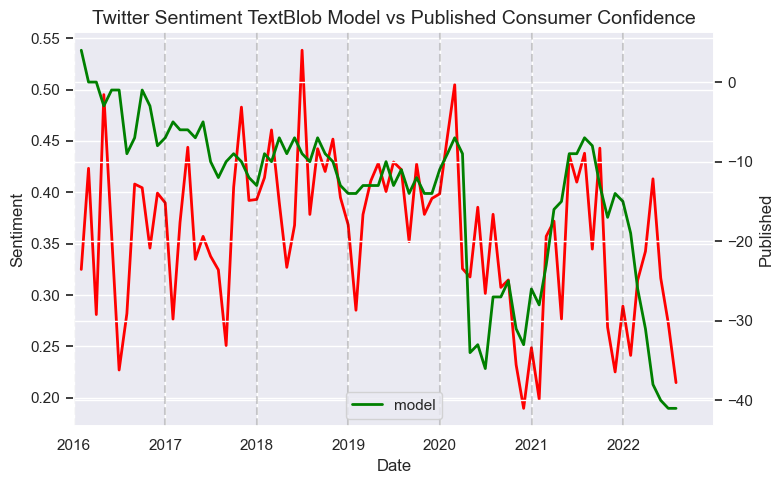

In [6]:
tb_result = (cleaned
.groupby([pd.Grouper(freq='M'),'tb_sentiment_score_round'])
.agg('sum',numeric_only=True)
.assign(tb_sentiment_score= lambda df_: abs(df_.tb_sentiment_score))
.iloc[3:,[0]]
.unstack()
.droplevel(0, axis=1)
.assign(tb_score =  lambda df_: (df_[1]- df_[-1])/(df_[1]+df_[0]+df_[-1]))
[['tb_score']]
.reset_index()
.pipe(lambda df_: df_.assign(date = df_.date.dt.strftime('%Y-%m-%d')))
.set_index('date')
.assign(published = df_published[:-1])
.pipe(lambda df_: df_.set_index(pd.to_datetime(df_.index, format='%Y-%m-%d')))
)

fig, ax1 = plt.subplots()
l1, = ax1.plot(tb_result.tb_score, color='red', linewidth=2, label='model')
ax2 = ax1.twinx()
l2, = ax2.plot(tb_result.published, color='green', linewidth=2, label='published')
plt.xticks(rotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment')
ax2.set_ylabel('Published')
plt.title('Twitter Sentiment TextBlob Model vs Published Consumer Confidence', fontsize=14)
plt.legend(['model', 'published'], loc='lower center')
plt.xlim([datetime.datetime(2015, 12, 31), datetime.datetime(2022, 12, 31)])
for year in range(2010, 2023):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()



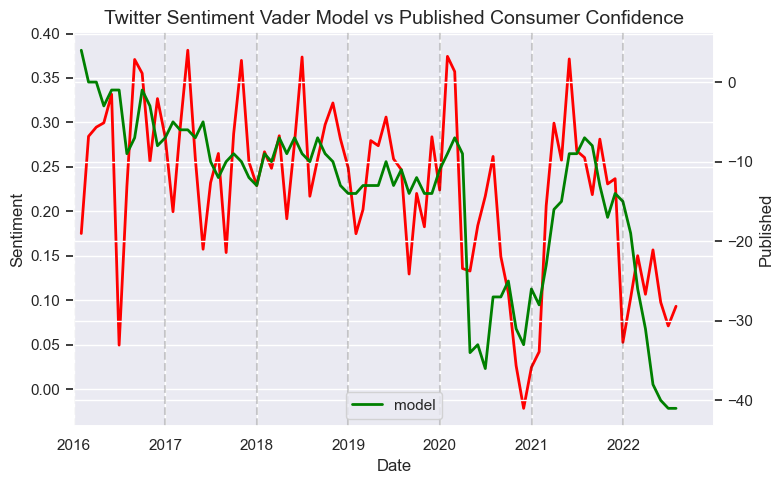

In [7]:
vd_result = (cleaned
.groupby([pd.Grouper(freq='M'),'vd_sentiment_score_round'])
.agg('sum',numeric_only=True)
.assign(vd_sentiment_score= lambda df_: abs(df_.vd_sentiment_score))
.iloc[3:,[1]]
.unstack()
.droplevel(0, axis=1)
.assign(vd_score =  lambda df_: (df_[1]- df_[-1])/(df_[1]+df_[0]+df_[-1]))
[['vd_score']]
.reset_index()
.pipe(lambda df_: df_.assign(date = df_.date.dt.strftime('%Y-%m-%d')))
.set_index('date')
.assign(published = df_published[:-1])
.pipe(lambda df_: df_.set_index(pd.to_datetime(df_.index, format='%Y-%m-%d')))
)


fig, ax1 = plt.subplots()
l1, = ax1.plot(vd_result.vd_score, color='red', linewidth=2, label='model')
ax2 = ax1.twinx()
l2, = ax2.plot(vd_result.published, color='green', linewidth=2, label='published')
plt.xticks(rotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment')
ax2.set_ylabel('Published')
plt.title('Twitter Sentiment Vader Model vs Published Consumer Confidence', fontsize=14)
plt.legend(['model', 'published'], loc='lower center')
plt.xlim([datetime.datetime(2015, 12, 31), datetime.datetime(2022, 12, 31)])
for year in range(2010, 2023):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

